# PBR geometry analysis

In [1]:
import laspy
import numpy as np
import os
import open3d as o3d
from joblib import Parallel, delayed
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors
import tqdm
from tqdm import tqdm

from utils import *
from filtering import *

import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

mission_a =['data/mission_a_0.las', 'data/mission_a_1.las', 'data/mission_a_2.las', 'data/mission_a_3.las']

## Density filtering

In [ ]:
radius = 0.3
density_threshold = 44

combined_density = []

for mission in mission_a[:]:
    points_semantics_source, colors = read_las_file(mission)
    points_semantics = points_semantics_source.copy()
    results = calculate_density(points_semantics, radius=radius, n_jobs=8)
    density = results[:, 1]
    combined_density.append(density)
    # plot a histogram of the density values
    plt.figure(figsize=(7, 3))
    plt.hist(density, bins=50, color='blue', alpha=0.7)
    # add density to the title 
    plt.title('Density Histogram (Radius = {:.2f})'.format(radius))
    plt.xlabel('Density')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

    points_semantics = points_semantics_source.copy()
    points_semantics = pc_filter(points_semantics, results, lower_bound_threshold=density_threshold)
    save_points_to_las(points_semantics, colors, f"{mission.split('.')[0]}_density.las")

# Combine all results into a single array
combined_density = np.concatenate(combined_density)
# Plot the combined histogram
plt.figure(figsize=(7, 3))
plt.hist(combined_density, bins=50, color='blue', alpha=0.7)
plt.title('Combined Density Histogram (Radius = {:.2f})'.format(radius))
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.grid()
plt.show()

        

## SOR filtering

In [16]:
mission_a_density = ['data/mission_a_0_density.las', 'data/mission_a_1_density.las', 'data/mission_a_2_density.las', 'data/mission_a_3_density.las']

for mission in mission_a_density:
    # Read the point cloud data
    points_semantics_source, colors = read_las_file(mission)
    points_semantics = points_semantics_source.copy()
    # Apply SOR filtering
    points_semantics = sor_filtering(points_semantics, n_neighbors=10, std_ratio=1.2)
    # Save the filtered point cloud
    save_points_to_las(points_semantics, colors, f"{mission.split('.')[0]}_sor.las")

(16456712, 4)
Number of points: 16456712
Number of semantics: 3351


SOR Filtering: 100%|██████████| 3351/3351 [00:02<00:00, 1458.11it/s]


Max intensity: 4322
(13556268, 4)
Number of points: 13556268
Number of semantics: 2665


SOR Filtering: 100%|██████████| 2665/2665 [00:00<00:00, 18693.63it/s]


Max intensity: 3775
(16467570, 4)
Number of points: 16467570
Number of semantics: 1856


SOR Filtering: 100%|██████████| 1856/1856 [00:00<00:00, 14549.81it/s]


Max intensity: 2584
(16082470, 4)
Number of points: 16082470
Number of semantics: 1892


SOR Filtering: 100%|██████████| 1892/1892 [00:00<00:00, 15581.49it/s]


Max intensity: 2887


## Vertical Face filtering

In [129]:
mission_a_density_sor = ['data/mission_a_0_density_sor.las', 'data/mission_a_1_density_sor.las', 'data/mission_a_2_density_sor.las', 'data/mission_a_3_density_sor.las']
hwr_threshold = 8

combined_hwr = []

for mission in mission_a_density_sor:
    # Read the point cloud data
    points_semantics_source, colors = read_las_file(mission)
    points_semantics = points_semantics_source.copy()
    # Compute the HWR values
    results = calculate_hwr(points_semantics, n_jobs=8)
    points_semantics = pc_filter(points_semantics, results, upper_bound_threshold=hwr_threshold)  # Filter based on HWR threshold
    # Save the filtered point cloud
    save_points_to_las(points_semantics, colors, f"{mission.split('.')[0]}_hwr.las")
    combined_hwr.append(results[:, 1])



(16456712, 4)
Number of points: 16456712
Number of semantics: 3351
Starting HWR computation...


Computing HWR: 100%|██████████| 3351/3351 [00:01<00:00, 1857.34it/s]


Unique semantics IDs before upper bound filtering: 3351
Unique semantics IDs after filtering: 3223
Max intensity: 4322
(13556268, 4)
Number of points: 13556268
Number of semantics: 2665
Starting HWR computation...


Computing HWR: 100%|██████████| 2665/2665 [00:00<00:00, 29640.03it/s]


Unique semantics IDs before upper bound filtering: 2665
Unique semantics IDs after filtering: 2589
Max intensity: 3775
(16467570, 4)
Number of points: 16467570
Number of semantics: 1856
Starting HWR computation...


Computing HWR: 100%|██████████| 1856/1856 [00:00<00:00, 24915.83it/s]


Unique semantics IDs before upper bound filtering: 1856
Unique semantics IDs after filtering: 1817
Max intensity: 2584
(16082470, 4)
Number of points: 16082470
Number of semantics: 1892
Starting HWR computation...


Computing HWR: 100%|██████████| 1892/1892 [00:00<00:00, 29404.48it/s]


Unique semantics IDs before upper bound filtering: 1892
Unique semantics IDs after filtering: 1840
Max intensity: 2887


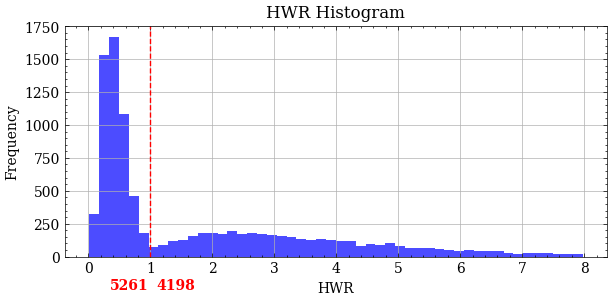

In [130]:
combined_hwr_array = np.concatenate(combined_hwr)
combined_hwr_array = combined_hwr_array[combined_hwr_array < hwr_threshold]  # Filter out values below the threshold

flat_hwr_N = np.sum(combined_hwr_array <= 1)  # Count the number of points below the threshold
vertical_hwr_N = np.sum(combined_hwr_array > 1)  # Count the number of points above the threshold

# Plot the combined histogram
plt.figure(figsize=(7, 3))
plt.hist(combined_hwr_array, bins=50, color='blue', alpha=0.7)
# draw a vertical line at 1
plt.axvline(x=1, color='red', linestyle='--', label='HWR Threshold')
# Add text annotation for flat and vertical counts in bold
plt.text(0.35, -250, f'{flat_hwr_N}', color='red', fontsize=10, fontweight='bold')
plt.text(1.1, -250, f'{vertical_hwr_N}', color='red', fontsize=10, fontweight='bold')

plt.title('HWR Histogram')
plt.xlabel('HWR')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Curvature filtering

In [ ]:
def calculate_normal_variation(points_semantics, radius=0.05, n_jobs=-1):
    """
    Compute normal angular deviation for each semantic segment.
    Angular deviation = std(acos(n_i ⋅ mean_normal))
    """
    def compute_normal_deviation(xyz, semantics_id):
        if len(xyz) < 3:
            return semantics_id, 0.0

        if len(xyz) > 500000:
            return semantics_id, 0.0  # Skip background points

        xyz = xyz.copy()  # ✅ Make array writable

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(xyz)

        try:
            pcd.estimate_normals(
                search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30)
            )
        except:
            return semantics_id, 0.0

        normals = np.asarray(pcd.normals)
        if len(normals) == 0:
            return semantics_id, 0.0

        mean_normal = np.mean(normals, axis=0)
        norm = np.linalg.norm(mean_normal)
        if norm < 1e-6:
            return semantics_id, 0.0
        mean_normal /= norm

        dot_products = np.clip(normals @ mean_normal, -1.0, 1.0)
        angles = np.arccos(dot_products)  # radians

        return semantics_id, np.std(angles)

    semantics_ids = np.unique(points_semantics[:, 3])
    id_to_xyz = group_xyz_by_semantics(points_semantics)

    print("Starting normal variation computation...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_normal_deviation)(id_to_xyz[sid], sid)
        for sid in tqdm(semantics_ids, desc="Computing normal deviation")
        if sid != -1
    )

    return np.array(results, dtype=object)

In [127]:
mission_a_density_sor_hwr = ['data/mission_a_0_density_sor_hwr.las', 'data/mission_a_1_density_sor_hwr.las', 'data/mission_a_2_density_sor_hwr.las', 'data/mission_a_3_density_sor_hwr.las']

points_semantics_source, colors = read_las_file(mission_a_density_sor[0])
points_semantics = points_semantics_source.copy()

results = calculate_normal_variation(points_semantics, n_jobs=8)


(16456712, 4)
Number of points: 16456712
Number of semantics: 3351
Starting normal variation computation...


Computing normal deviation: 100%|██████████| 3351/3351 [00:00<00:00, 17712.74it/s]


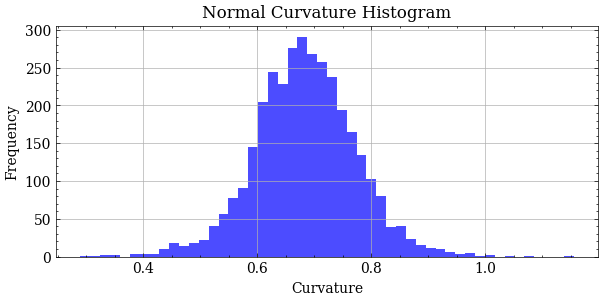

Unique semantics IDs before upper bound filtering: 3351
Unique semantics IDs after filtering: 81
Max intensity: 4201


In [128]:
# plot the curvature values
plt.figure(figsize=(7, 3))
plt.hist(results[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Normal Curvature Histogram')
plt.xlabel('Curvature')
plt.ylabel('Frequency')
plt.grid()
plt.show()


points_semantics = pc_filter(points_semantics, results, upper_bound_threshold=0.5)  # Filter based on curvature threshold
save_points_to_las(points_semantics, colors, f"{mission_a_density_sor_hwr[0].split('.')[0]}_normal_curvature.las")


In [120]:
curvature_dict = {}
for semantics_id, curvature in results:
    curvature_dict[semantics_id] = curvature

print(curvature_dict[3638])

0.11213444289559603


## HWR analysis

In [ ]:
mission_a_density_sor_hwr = ['data/mission_a_0_density_sor_hwr.las', 'data/mission_a_1_density_sor_hwr.las', 'data/mission_a_2_density_sor_hwr.las', 'data/mission_a_3_density_sor_hwr.las']
hwr_filter_threshold = 2
curvature_threshold = 0.1

combined_hwr = []
combined_curvature = []
combined_filtered_curvature = []

for i, mission in enumerate(mission_a_density_sor_hwr):
    # Read the point cloud data
    points_semantics_source, colors = read_las_file(mission)

    points_semantics = points_semantics_source.copy()

    results = calculate_hwr(points_semantics, n_jobs=8)
    points_semantics = pc_filter(points_semantics, results, lower_bound_threshold=hwr_filter_threshold)
    
    results = calculate_pca_curvature(points_semantics, n_jobs=8)
    combined_curvature.append(results[:, 1])  # Store curvature results
    combined_filtered_curvature.append(results[results[:, 1] > curvature_threshold, 1])  # Filter curvature results

    points_semantics = pc_filter(points_semantics, results, lower_bound_threshold=curvature_threshold)
    results = calculate_hwr(points_semantics, n_jobs=8)
    combined_hwr.append(results[:, 1])

    save_points_to_las(points_semantics, colors, f"{mission.split('.')[0]}_pca_curvature.las")

combined_hwr = np.concatenate(combined_hwr)
combined_curvature = np.concatenate(combined_curvature)
combined_filtered_curvature = np.concatenate(combined_filtered_curvature)

In [96]:
mission_a_density_sor_hwr = ['data/mission_a_0_density_sor_hwr.las', 'data/mission_a_1_density_sor_hwr.las', 'data/mission_a_2_density_sor_hwr.las', 'data/mission_a_3_density_sor_hwr.las']

points_semantics_source, colors = read_las_file(mission_a_density_sor_hwr[0])
points_semantics = points_semantics_source.copy()
results_hwr = calculate_hwr(points_semantics, n_jobs=8)

points_semantics_source, colors = read_las_file(mission_a_density_sor_hwr[0])
points_semantics = points_semantics_source.copy()
results_curvature = calculate_pca_curvature(points_semantics, n_jobs=8)

(16456712, 4)
Number of points: 16456712
Number of semantics: 3222
Starting HWR computation...


Computing HWR: 100%|██████████| 3222/3222 [00:00<00:00, 31321.74it/s]


(16456712, 4)
Number of points: 16456712
Number of semantics: 3222
Starting PCA curvature computation...


Computing PCA curvature: 100%|██████████| 3222/3222 [00:00<00:00, 37916.61it/s]


In [97]:
curvature_dict = {}
for semantics_id, curvature in results_curvature:
    curvature_dict[semantics_id] = curvature

hwr_dict = {}
for semantics_id, hwr in results_hwr:
    hwr_dict[semantics_id] = hwr

print(curvature_dict[3943])
print(hwr_dict[3943])

0.01424798695771688
6.135932723922306


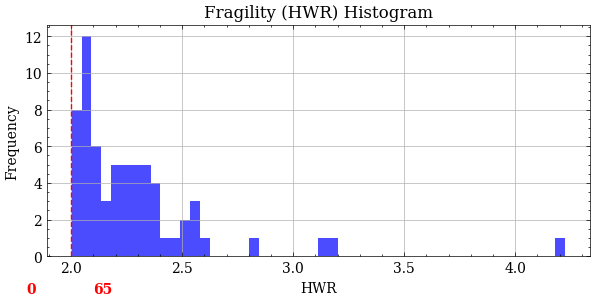

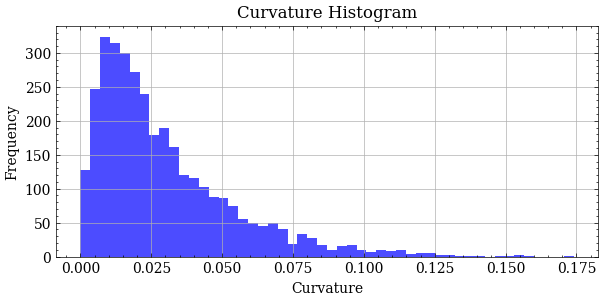

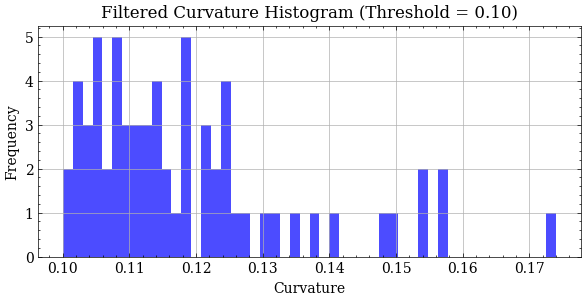

In [3]:
# plot the combined HWR histogram
plt.figure(figsize=(7, 3))
plt.hist(combined_hwr, bins=50, color='blue', alpha=0.7)
# draw a vertical line at 2
plt.axvline(x=hwr_filter_threshold, color='red', linestyle='--', label='HWR Threshold')
flat_hwr_N = np.sum(combined_hwr <= 2)  # Count the number of points below the threshold
vertical_hwr_N = np.sum(combined_hwr > 2)  # Count the number of points above the threshold
plt.text(hwr_filter_threshold-0.2, -2, f'{flat_hwr_N}', color='red', fontsize=10, fontweight='bold')
plt.text(hwr_filter_threshold+0.1, -2, f'{vertical_hwr_N}', color='red', fontsize=10, fontweight='bold')
plt.title('Fragility (HWR) Histogram')
plt.xlabel('HWR')
plt.ylabel('Frequency')
plt.grid()
plt.show()      

# plot the combined curvature histogram
plt.figure(figsize=(7, 3))
plt.hist(combined_curvature, bins=50, color='blue', alpha=0.7)
plt.title('Curvature Histogram')
plt.xlabel('Curvature')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# plot the filtered curvature histogram
plt.figure(figsize=(7, 3))
plt.hist(combined_filtered_curvature, bins=50, color='blue', alpha=0.7)
plt.title('Filtered Curvature Histogram (Threshold = {:.2f})'.format(curvature_threshold))
plt.xlabel('Curvature')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [4]:
mission_a_density_sor_hwr_pca = ['data/mission_a_0_density_sor_hwr_pca_curvature.las',
                                  'data/mission_a_1_density_sor_hwr_pca_curvature.las',
                                  'data/mission_a_2_density_sor_hwr_pca_curvature.las',
                                  'data/mission_a_3_density_sor_hwr_pca_curvature.las']

points_semantics_source, colors = read_las_files(mission_a_density_sor_hwr_pca)
points_semantics = points_semantics_source.copy()

# compute hwr 
results = calculate_hwr(points_semantics, n_jobs=8)

(16456712, 4)
Number of points: 16456712
Number of semantics: 24
(13556268, 4)
Number of points: 13556268
Number of semantics: 17
(16467570, 4)
Number of points: 16467570
Number of semantics: 15
(16082470, 4)
Number of points: 16082470
Number of semantics: 13
Starting HWR computation...


Computing HWR: 100%|██████████| 66/66 [00:00<00:00, 4141.53it/s]


In [5]:
# save the points with hwr
save_points_to_las(points_semantics, colors, 'data/mission_a_density_sor_hwr_pca_curvature.las')

Max intensity: 13436


In [33]:
semantics_hwr = {}
for result in results:
    semantics_id = int(result[0])
    hwr_value = float(result[1])
    semantics_hwr[semantics_id] = hwr_value

print(semantics_hwr)

{778: 2.053839256745169, 801: 2.089300901108458, 1514: 2.2698559548904904, 1518: 2.0874272729011034, 1901: 2.033300019675024, 1942: 2.127984842239006, 2133: 2.1363619097608715, 2175: 2.3934116914777426, 2188: 2.0942454853102093, 2561: 2.319502055865612, 2567: 2.5178385376990584, 3062: 2.037613276861437, 3624: 2.33648171072913, 3638: 2.13391624525234, 3684: 2.3178052076204603, 3781: 2.028803794272457, 3789: 2.06998087624438, 3802: 2.30205941996255, 3824: 2.308770045211517, 4051: 2.0860056681080565, 4116: 3.186349812889526, 4241: 2.3827081173825087, 4266: 4.224115996449866, 5320: 2.0545569533183623, 5468: 2.2174784623348613, 6287: 2.313488881008076, 6906: 2.00268643792548, 6981: 2.4987331037189726, 7124: 2.832252995101646, 7130: 2.076387759766835, 7559: 2.3941464860977137, 7742: 2.0978148920290276, 7808: 3.135785840092044, 7841: 2.0468193141241087, 7845: 2.2281281290932506, 7848: 2.0904066901010774, 7858: 2.546913752375564, 7976: 2.293825080756766, 7997: 2.26504377105384, 8174: 2.3328392

In [34]:
# Sort remaining semantic IDs by their HWR values (ascending order)
sorted_semantics = sorted(semantics_hwr.items(), key=lambda x: x[1])  # (sem_id, hwr)
old_to_new_id = {old_id: new_id for new_id, (old_id, _) in enumerate(sorted_semantics)}

# Apply the new semantic ID mapping
for old_id, new_id in old_to_new_id.items():
    indices = np.where(points_semantics[:, 3] == old_id)[0]
    points_semantics[indices, 3] = new_id

print(f"Assigned new semantic IDs from 0 to {len(old_to_new_id)-1}")

save_points_to_las(points_semantics, colors, "data/mission_a_hwr_sorted.las")

Assigned new semantic IDs from 0 to 64
Max intensity: 13436


In [78]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import cv2
from numba import njit
from tqdm import tqdm

def draw_transparent_circle(image, center, radius, color, alpha=0.5):
    overlay = image.copy()
    cv2.circle(overlay, center, radius, color, -1)
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

@njit
def paint_pixels(xyz, colors, x_min, y_min, resolution, width_size, height_size, ortho):
    for i in range(xyz.shape[0]):
        x_pixel = int((xyz[i, 0] - x_min) / resolution)
        y_pixel = int((xyz[i, 1] - y_min) / resolution)
        if 0 <= x_pixel < width_size and 0 <= y_pixel < height_size:
            ortho[y_pixel, x_pixel, :] = colors[i]
    return ortho

def voxel_orthomosaic(points_semantics, colors, semantics_hwr, resolution=0.01):
    xyz = points_semantics[:, :3]
    semantics = points_semantics[:, 3].astype(int)

    # Normalize colors to 0–255 uint8
    colors_uint8 = ((colors / 65535) * 255).astype(np.uint8)

    # Compute canvas dimensions
    x_min, x_max = np.min(xyz[:, 0]), np.max(xyz[:, 0])
    y_min, y_max = np.min(xyz[:, 1]), np.max(xyz[:, 1])
    width_size = int(np.ceil((x_max - x_min) / resolution))
    height_size = int(np.ceil((y_max - y_min) / resolution))

    ortho = np.full((height_size, width_size, 3), 255, dtype=np.uint8)

    # Paint point cloud colors
    ortho = paint_pixels(xyz, colors_uint8, x_min, y_min, resolution, width_size, height_size, ortho)

    # HWR color map
    hwr_array = np.array(list(semantics_hwr.values()))
    norm = mcolors.Normalize(vmin=hwr_array.min(), vmax=hwr_array.max())
    cmap = cm.get_cmap('gist_ncar')

    for sid in tqdm(np.unique(semantics), desc="Overlay Circles"):
        if sid not in semantics_hwr.keys():
            continue
        cluster = xyz[semantics == sid]
        center = cluster.mean(axis=0)
        hwr = semantics_hwr[sid]
        rgba = cmap(norm(hwr))
        color = tuple(int(255 * c) for c in rgba[:3])
        x_pixel = int((center[0] - x_min) / resolution)
        y_pixel = int((center[1] - y_min) / resolution)
        if 0 <= x_pixel < width_size and 0 <= y_pixel < height_size:
            draw_transparent_circle(ortho, (x_pixel, y_pixel), 40, color, alpha=0.7)

    print(f"Orthomosaic size: Width = {width_size}, Height = {height_size}")
    return ortho, x_min, y_min

In [67]:
points_semantics_source, colors = read_las_file("data/mission_a_hwr_sorted.las")
results = calculate_hwr(points_semantics_source, n_jobs=8)
semantics_hwr = {}
for result in results:
    semantics_id = int(result[0])
    hwr_value = float(result[1])
    semantics_hwr[semantics_id] = hwr_value

(62563020, 4)
Number of points: 62563020
Number of semantics: 66
Starting HWR computation...


Computing HWR: 100%|██████████| 66/66 [00:01<00:00, 39.05it/s]


In [79]:
ortho_image, x_min, y_min = voxel_orthomosaic(points_semantics, colors, semantics_hwr, resolution=0.05)

/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_71875/868837937.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_ncar')
Overlay Circles: 100%|██████████| 66/66 [00:05<00:00, 11.06it/s]

Orthomosaic size: Width = 6503, Height = 7121


/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_71875/1948866687.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_ncar')


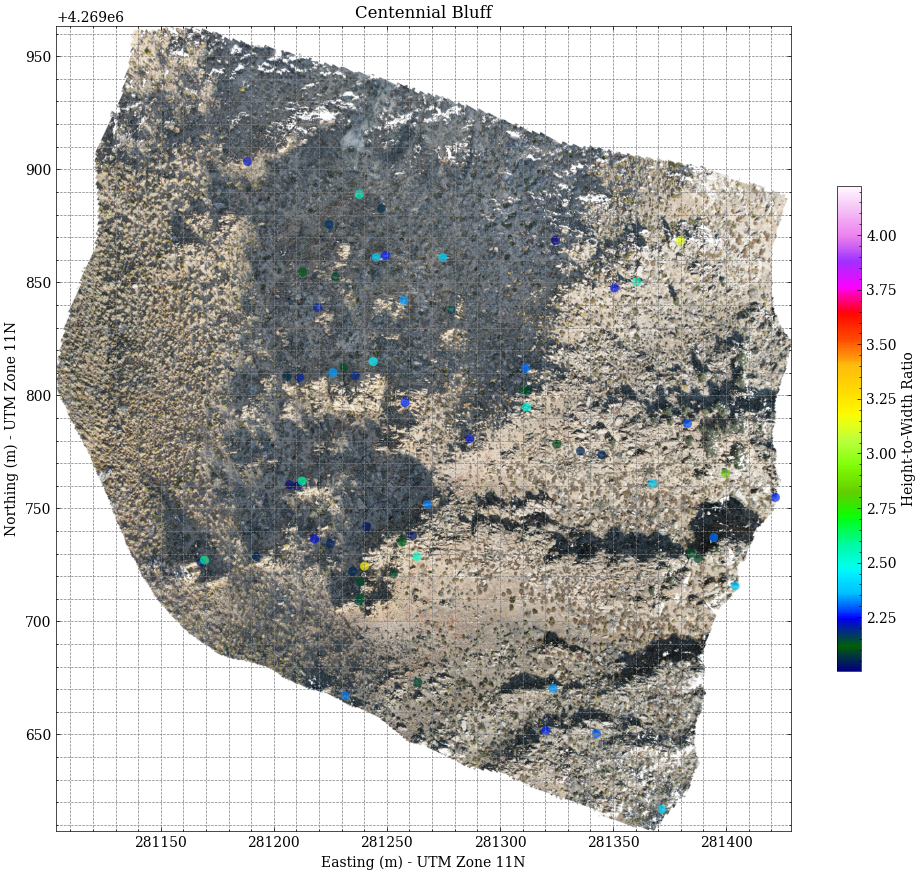

In [80]:
def plot_orthomap(ortho_image, x_min, y_min, resolution, semantics_hwr):
    H, W, _ = ortho_image.shape

    # Compute extent
    x_max = x_min + W * resolution
    y_max = y_min + H * resolution
    extent = [x_min, x_max, y_min, y_max]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Show ortho image
    im = ax.imshow(ortho_image, extent=extent, origin='lower', zorder=1)

    # Set axis labels and title
    ax.set_xlabel("Easting (m) - UTM Zone 11N")
    ax.set_ylabel("Northing (m) - UTM Zone 11N")
    ax.set_title("Centennial Bluff")

    # Grid settings
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', zorder=0)
    ax.set_aspect('equal')

    # Set up colorbar for HWR values
    hwr_values = list(semantics_hwr.values())
    vmin = min(hwr_values)
    vmax = max(hwr_values)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap('gist_ncar')

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
    cbar.set_label("Height-to-Width Ratio")

    plt.tight_layout()
    # save 
    plt.savefig("data/centennial_bluff_ortho_map.png", dpi=300)
    plt.show()


plot_orthomap(ortho_image, x_min, y_min, resolution=0.05, semantics_hwr=semantics_hwr)

In [11]:
def impose_color_to_semantics_points(points_semantics, colors, semantics_hwr):
    # Create a color map
    hwr_array = np.array(list(semantics_hwr.values()))
    norm = mcolors.Normalize(vmin=hwr_array.min(), vmax=hwr_array.max())
    cmap = cm.get_cmap('jet')

    # Create a new color array
    color_array = colors.copy()

    for semantics_id, hwr in semantics_hwr.items():
        indices = np.where(points_semantics[:, 3] == semantics_id)[0]

        # if the indices number is greater than 10% of the points, set the color to the orginal color
        if len(indices) < len(points_semantics) / 10:
            # Get the color from the colormap
            rgba = cmap(norm(hwr))
            color = tuple(int(255 * 255 * c) for c in rgba[:3])
            color_array[indices] = color

    return color_array


new_colors = impose_color_to_semantics_points(points_semantics, colors, semantics_hwr)
save_points_to_las(points_semantics, new_colors, "data/centennial_bluff_mission_a_0_sorted_color.las")

/var/folders/hd/v79cys4d00n4d9rywlwq4ph40000gn/T/ipykernel_71875/926329926.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


Max intensity: 13436


In [177]:
semantics_hwr

{np.float64(873.0): np.float64(1.9767121476210872),
 np.float64(1208.0): np.float64(0.8135520103717715),
 np.float64(1216.0): np.float64(0.7558043781313792),
 np.float64(1389.0): np.float64(0.7301165427642232),
 np.float64(1634.0): np.float64(0.8035751826105325),
 np.float64(2153.0): np.float64(0.8193172764320754),
 np.float64(2200.0): np.float64(1.2016136672529896),
 np.float64(2302.0): np.float64(0.8130825177515901),
 np.float64(2439.0): np.float64(1.4694364339345625),
 np.float64(2621.0): np.float64(1.9330190269809255),
 np.float64(2990.0): np.float64(0.9381970519928561),
 np.float64(3236.0): np.float64(0.7949048682321201),
 np.float64(3239.0): np.float64(1.1720314394005655),
 np.float64(3290.0): np.float64(1.3009693595787866),
 np.float64(3615.0): np.float64(0.7184035823860346),
 np.float64(3648.0): np.float64(1.385622139712938),
 np.float64(3663.0): np.float64(1.3061556188631522),
 np.float64(3678.0): np.float64(1.0467931786156406),
 np.float64(3998.0): np.float64(0.64049459872932

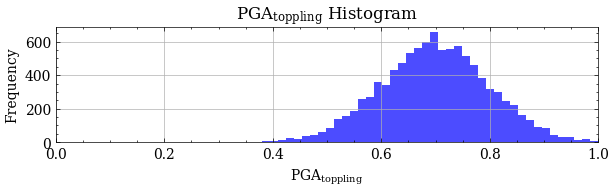

In [97]:
def truncated_gaussian_sampling(mu, sigma, A, B, size, random_state=None):
    """
    Sample from a truncated Gaussian distribution within [A, B].

    Parameters:
        mu (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian.
        A (float): Lower bound of the range.
        B (float): Upper bound of the range.
        size (int): Number of samples to generate.
        random_state (int or None): Seed for reproducibility.

    Returns:
        np.ndarray: Array of samples within [A, B].
    """
    rng = np.random.default_rng(random_state)
    samples = []

    while len(samples) < size:
        sample = rng.normal(mu, sigma)
        if A <= sample <= B:
            samples.append(sample)

    return np.array(samples)


samples = truncated_gaussian_sampling(mu=0.7, sigma=0.1, A=0.0, B=1.0, size=10000, random_state=42)
# Plot the histogram of the samples
plt.figure(figsize=(7, 1.5))
plt.hist(samples, bins=50, color='blue', alpha=0.7)
plt.title(r'$\mathrm{PGA}_{\mathrm{toppling}}$ Histogram')
plt.xlabel(r'$\mathrm{PGA}_{\mathrm{toppling}}$')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.grid()
plt.show()
# Save the sampled HWR values to a file

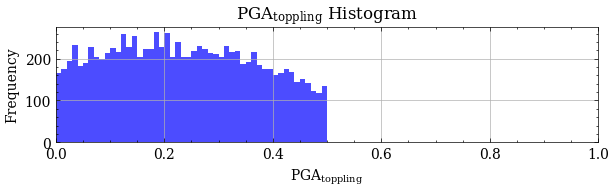

In [98]:
samples = truncated_gaussian_sampling(mu=0.2, sigma=0.3, A=0.0, B=0.5, size=10000, random_state=42)

# Plot the histogram of the samples
plt.figure(figsize=(7, 1.5))
plt.hist(samples, bins=50, color='blue', alpha=0.7)
plt.title(r'$\mathrm{PGA}_{\mathrm{toppling}}$ Histogram')
plt.xlabel(r'$\mathrm{PGA}_{\mathrm{toppling}}$')
# set x limit to [0, 10]
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.grid()
plt.show()


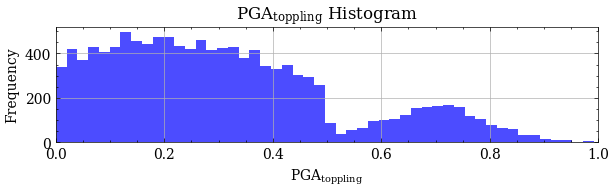

In [99]:
samples_ = truncated_gaussian_sampling(mu=0.7, sigma=0.1, A=0.0, B=1.0, size=2000, random_state=42)

new_samples = np.concatenate((samples, samples_))
# Plot the histogram of the new samples
plt.figure(figsize=(7, 1.5))
plt.hist(new_samples, bins=50, color='blue', alpha=0.7)
plt.title(r'$\mathrm{PGA}_{\mathrm{toppling}}$ Histogram')
plt.xlabel(r'$\mathrm{PGA}_{\mathrm{toppling}}$')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.grid()
plt.show()